In [3]:

from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage
from typing_extensions import TypedDict, Literal


class Route(BaseModel):
    step:Literal["poem", "story", "joke"]= Field(description="The next step in the process")

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model = "gpt-4o")

router = llm.with_structured_output(Route)


In [5]:
class State(TypedDict):
    input:str
    decision:str
    output:str

def llm_call1(state: State):
    """write a story"""
    result = llm.invoke(state["input"])
    return {"output":result.content}

def llm_call2(state: State):
    """write a joke"""
    result = llm.invoke(state["input"])
    return {"output":result.content}

def llm_call3(state: State):
    """write a poem"""
    result = llm.invoke(state["input"])
    return {"output":result.content}


def llm_router(state: State):
    """Route the input to appropriate node"""

    decision = router.invoke(
        [
        SystemMessage(
            content = "Route the input to story, joke, or poem based on the users request"
        ),
        HumanMessage(content = state["input"])
        ]
    )
    return {"decision":decision.step}

def router_decision(state: State):
    if state["decision"]=="story":
        return "llm_call1"
    elif state["decision"]=="joke":
        return "llm_call2"
    elif state["decision"]=="poem":
        return "llm_call3"
    


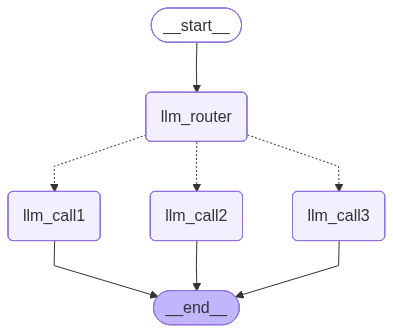

In [6]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

graph = StateGraph(State)
graph.add_node("llm_call1", llm_call1)
graph.add_node("llm_call2", llm_call2)
graph.add_node("llm_call3", llm_call3)
graph.add_node("llm_router", llm_router)

graph.add_edge(START, "llm_router")
graph.add_conditional_edges(
    "llm_router",router_decision,
    {
        #which node to call according to output
        "llm_call1": "llm_call1",
        "llm_call2": "llm_call2",
        "llm_call3":"llm_call3"
    }
)
graph.add_edge("llm_call1", END)
graph.add_edge("llm_call2", END)
graph.add_edge("llm_call3", END)

builder = graph.compile()

display(Image(builder.get_graph().draw_mermaid_png()))


In [7]:
builder.invoke({"input": "Write me a joke about agenti AI sytem"})

{'input': 'Write me a joke about agenti AI sytem',
 'decision': 'joke',
 'output': 'Why did the AI agent apply for a job at the comedy club?\n\nIt heard they were looking for someone with a great "sense of compute"!'}